In [43]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [44]:
# Define the transforms for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [45]:
# Set the paths to dataset
train_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
val_data_path = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

In [46]:
# Load the dataset
train_dataset = ImageFolder(root=train_data_path, transform=transform)
test_dataset = ImageFolder(root=test_data_path, transform=transform)
val_dataset = ImageFolder(root=val_data_path, transform=transform)

In [47]:
# Set the hyperparameters
batch_size = 128
num_epochs = 10
learning_rate = 0.001

In [48]:
# Create data loaders for training and validation
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [49]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1 ,2, 0)))
    plt.show()

In [50]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

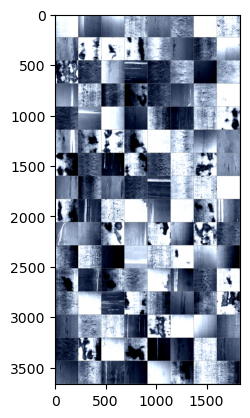

In [51]:
# show images 
imshow(torchvision.utils.make_grid(images))

In [52]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [53]:
# Initialize the model
model = AlexNet(num_classes=len(train_dataset.classes))

In [54]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
train_accuracy_values = []
train_loss_values = []
val_accuracy_values = []
val_loss_values = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Calculate training accuracy and loss
    train_accuracy = correct_predictions / total_predictions
    train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            running_loss += loss.item()

    # Calculate validation accuracy and loss
    val_accuracy = correct_predictions / total_predictions
    val_loss = running_loss / len(val_loader)

    # Append values to the lists
    train_accuracy_values.append(train_accuracy)
    train_loss_values.append(train_loss)
    val_accuracy_values.append(val_accuracy)
    val_loss_values.append(val_loss)

    # Print or log the values if needed
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

Epoch [1/10] - Train Loss: 2.1333, Train Accuracy: 0.1957 - Val Loss: 1.6323, Val Accuracy: 0.3194
Epoch [2/10] - Train Loss: 1.6556, Train Accuracy: 0.2790 - Val Loss: 1.5795, Val Accuracy: 0.3194
Epoch [3/10] - Train Loss: 1.4960, Train Accuracy: 0.3551 - Val Loss: 1.2611, Val Accuracy: 0.5278
Epoch [4/10] - Train Loss: 1.4765, Train Accuracy: 0.4076 - Val Loss: 1.2471, Val Accuracy: 0.4306
Epoch [5/10] - Train Loss: 1.2729, Train Accuracy: 0.4607 - Val Loss: 1.4452, Val Accuracy: 0.4028
Epoch [6/10] - Train Loss: 1.1581, Train Accuracy: 0.5048 - Val Loss: 0.7794, Val Accuracy: 0.6389
Epoch [7/10] - Train Loss: 0.9241, Train Accuracy: 0.6123 - Val Loss: 0.7420, Val Accuracy: 0.6944
Epoch [8/10] - Train Loss: 0.9260, Train Accuracy: 0.6419 - Val Loss: 0.8166, Val Accuracy: 0.6667
Epoch [9/10] - Train Loss: 0.7523, Train Accuracy: 0.7041 - Val Loss: 0.3531, Val Accuracy: 0.8750
Epoch [10/10] - Train Loss: 0.4467, Train Accuracy: 0.8502 - Val Loss: 0.2547, Val Accuracy: 0.9583


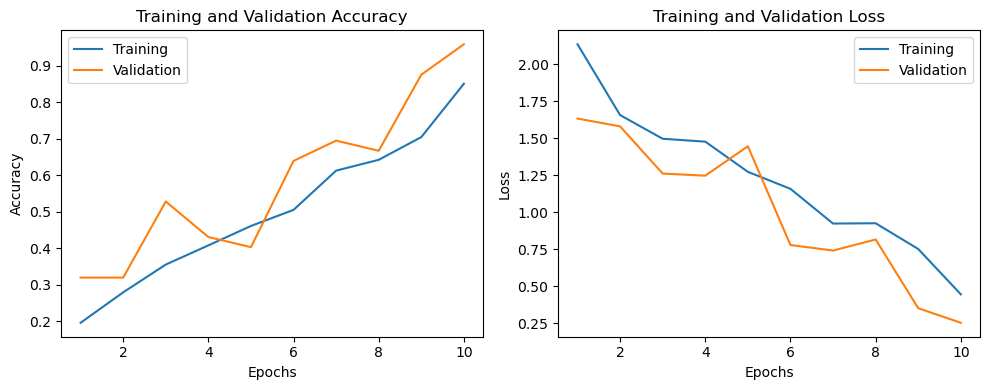

In [56]:
# Plot accuracy curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy_values) + 1), train_accuracy_values, label='Training')
plt.plot(range(1, len(val_accuracy_values) + 1), val_accuracy_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label='Training')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [57]:
# Evaluate the model

model.eval()

# Lists to store predicted and true labels
predicted_labels = []
true_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy().tolist())
        true_labels.extend(labels.numpy().tolist())
        
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
  

Accuracy: 0.8056
Precision: 0.8395
Recall: 0.8056
F1 Score: 0.8098
